## Train and Prediction on valid data

Using rotated to hz + OpenCv border

Basic default transforms

see:

https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/cnn_archs.ipynb

and

https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/cnn_archs_more.ipynb

mem use 3GB with bs=32 TODO increase

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from torchvision.models import *
from efficientnet_pytorch import EfficientNet
import pretrainedmodels

In [3]:
from fastai.vision import *
from fastai.vision.models import *
from fastai.vision.learner import model_meta
from callbacks import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join

In [4]:
__version__

'1.0.59.dev0'

In [5]:
m = EfficientNet.from_pretrained('efficientnet-b4')

Loaded pretrained weights for efficientnet-b4


In [6]:
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')

In [7]:
def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []

In [8]:
arch_summary(lambda _: m)

(0) Conv2dStaticSamePadding: 2   layers (total: 2)
(1) BatchNorm2d : 1   layers (total: 3)
(2) ModuleList  : 506 layers (total: 509)
(3) Conv2dStaticSamePadding: 2   layers (total: 511)
(4) BatchNorm2d : 1   layers (total: 512)
(5) AdaptiveAvgPool2d: 1   layers (total: 513)
(6) Dropout     : 1   layers (total: 514)
(7) Linear      : 1   layers (total: 515)
(8) MemoryEfficientSwish: 1   layers (total: 516)


In [9]:
arch_summary(lambda _: list(m.children())[2])

(0) MBConvBlock : 13  layers (total: 13)
(1) MBConvBlock : 13  layers (total: 26)
(2) MBConvBlock : 16  layers (total: 42)
(3) MBConvBlock : 16  layers (total: 58)
(4) MBConvBlock : 16  layers (total: 74)
(5) MBConvBlock : 16  layers (total: 90)
(6) MBConvBlock : 16  layers (total: 106)
(7) MBConvBlock : 16  layers (total: 122)
(8) MBConvBlock : 16  layers (total: 138)
(9) MBConvBlock : 16  layers (total: 154)
(10) MBConvBlock : 16  layers (total: 170)
(11) MBConvBlock : 16  layers (total: 186)
(12) MBConvBlock : 16  layers (total: 202)
(13) MBConvBlock : 16  layers (total: 218)
(14) MBConvBlock : 16  layers (total: 234)
(15) MBConvBlock : 16  layers (total: 250)
(16) MBConvBlock : 16  layers (total: 266)
(17) MBConvBlock : 16  layers (total: 282)
(18) MBConvBlock : 16  layers (total: 298)
(19) MBConvBlock : 16  layers (total: 314)
(20) MBConvBlock : 16  layers (total: 330)
(21) MBConvBlock : 16  layers (total: 346)
(22) MBConvBlock : 16  layers (total: 362)
(23) MBConvBlock : 16  laye

In [10]:
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [11]:
data_dir_02 = Path('data_02')
data_dir = Path('data')

In [12]:
RETRAIN = True
RESIZE_IMAGES = True

In [13]:
MODEL_NAME='efficientnet'

In [14]:
NB_NUM='06_16'

In [15]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: 97c78fc0, DATE: 20191130


In [16]:
DATE = '20191128'
UID = '3c19f55d'

In [17]:
SUB_NUM='24'

In [18]:
img_size=256
bs=32
border='reflect'
cutoff='blk_cutoff_25'

In [19]:
train_images=data_dir_02/f'train/rotated/clipped/{border}/{cutoff}/{img_size}'
#train image folder is same as test
test_images=data_dir_02/f'test/rotated/clipped/{border}/{cutoff}/{img_size}'

In [20]:
test_names = get_image_files(test_images)

In [21]:
#assert len(test_names)==7325

In [22]:
df_all=pd.read_csv(data_dir/'df_all_repl_st_lucia_castries_gold_concrete_cement.csv')

In [23]:
df_all.drop(columns=['target'],inplace=True)

In [24]:
df_valid=df_all.loc[df_all['verified'] == True]

### Note we are predicting the unverified images

In [25]:
df_test=df_all.loc[df_all['verified'] == False]

In [26]:
#df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [27]:
df_test.tail()

,country,id,region,roof_material,verified
22459,st_lucia,7a22ddec,gros_islet,healthy_metal,False
22460,st_lucia,7a2f73ea,gros_islet,healthy_metal,False
22461,st_lucia,7a34ffa4,gros_islet,healthy_metal,False
22462,st_lucia,7a41560a,gros_islet,healthy_metal,False
22463,st_lucia,7a283ad0,gros_islet,healthy_metal,False


In [28]:
xtra_tfms=[dihedral(p=0.05), rand_crop(p=0.4)]
tfms = get_transforms(flip_vert=True, max_lighting=0.2, max_zoom=1.25, max_warp=0., xtra_tfms=xtra_tfms)

### setup dataset

In [29]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_valid, cols='id', suffix='.tif')
       .split_by_rand_pct(0.1)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

14945


In [30]:
data = (src.transform(tfms, size=img_size)
        .databunch(bs=bs).normalize(imagenet_stats))

In [31]:
#to check what params object has
#dir(data)

In [32]:
data.label_list

LabelLists;

Train: LabelList (13451 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/reflect/blk_cutoff_25/256;

Valid: LabelList (1494 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,healthy_metal,concrete_cement,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/reflect/blk_cutoff_25/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_02/train/rotated/clipped/reflect/blk_cutoff_25/256

In [33]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

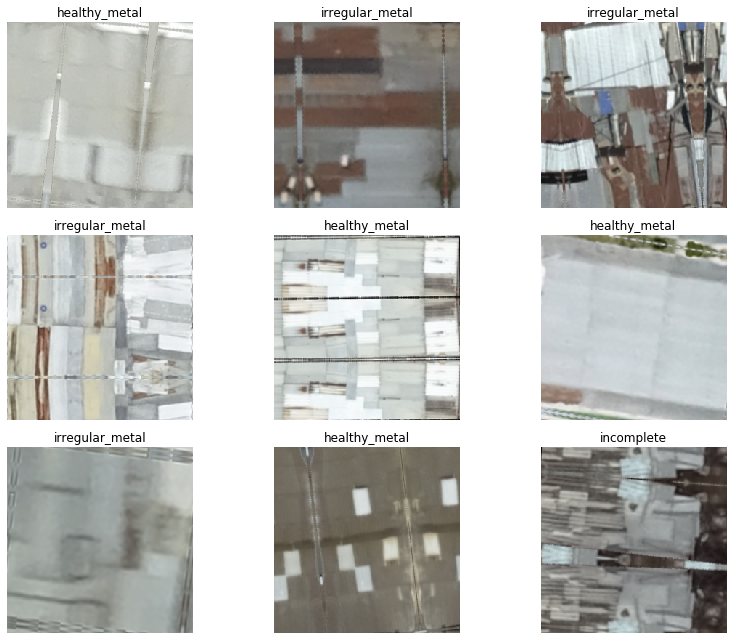

In [34]:
data.show_batch(rows=3, figsize=(12,9))

In [35]:
def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []

### Model

In [36]:
# "pretrained" is hardcoded to adapt to the PyTorch model function
def efficient_net_b4(pretrained=True):
    model = EfficientNet.from_pretrained('efficientnet-b4')
    return nn.Sequential(model)

In [37]:
model_meta[efficient_net_b4] =  { 'cut': noop, 
                               'split': lambda m: (list(m[0][0].children())[2][7], m[1]) }

In [38]:
list(efficient_net_b4()[0].children())

Loaded pretrained weights for efficientnet-b4


[Conv2dStaticSamePadding(
   3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
   (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
 ),
 BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True),
 ModuleList(
   (0): MBConvBlock(
     (_depthwise_conv): Conv2dStaticSamePadding(
       48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
       (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
     )
     (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_se_reduce): Conv2dStaticSamePadding(
       48, 12, kernel_size=(1, 1), stride=(1, 1)
       (static_padding): Identity()
     )
     (_se_expand): Conv2dStaticSamePadding(
       12, 48, kernel_size=(1, 1), stride=(1, 1)
       (static_padding): Identity()
     )
     (_project_conv): Conv2dStaticSamePadding(
       48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False
       (static_padding): Identi

In [39]:
output_size = list(efficient_net_b4()[0].children())[-2].out_features

Loaded pretrained weights for efficientnet-b4


In [40]:
output_size

1000

In [41]:
custom_head = nn.Linear(output_size, data.c)

In [42]:
arch = efficient_net_b4
arch_name = 'efficient_net_b4'

In [43]:
learn = cnn_learner(data, arch, custom_head = custom_head, metrics=error_rate, bn_final=True).to_fp16()

Loaded pretrained weights for efficientnet-b4


In [44]:
get_groups(nn.Sequential(*list(learn.model[0][0].children())[:2], 
                         *list(learn.model[0][0].children())[2],
                         *list(learn.model[0][0].children())[3:],
                         learn.model[1]), 
           learn.layer_groups)

Group 1: ['Conv2dStaticSamePadding', 'BatchNorm2d', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock']
Group 2: ['MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'MBConvBlock', 'Conv2dStaticSamePadding', 'BatchNorm2d', 'AdaptiveAvgPool2d', 'Dropout', 'Linear', 'MemoryEfficientSwish']
Group 3: ['Linear']


In [45]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

In [46]:
save_name=f'best-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}'
callbacks = [SaveModelCallback(learn, every='improvement', monitor='valid_loss', name=save_name, uid=UID)]

We use the LR Finder to pick a good learning rate.

### train model

In [47]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


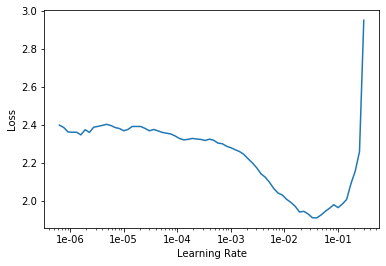

In [48]:
learn.recorder.plot()

Then we can fit the head of our network.

In [49]:
lr = 5e-3

In [50]:
learn.fit_one_cycle(15, slice(lr), callbacks=callbacks)

epoch,train_loss,valid_loss,error_rate,time
0,1.008041,0.934998,0.343374,01:53
1,0.886815,0.867647,0.337349,01:52
2,0.950891,0.873662,0.333333,01:52
3,0.905761,0.876334,0.300535,01:52
4,0.904558,0.848041,0.295181,01:52
5,0.889505,0.740643,0.275770,01:52
6,0.807986,0.703647,0.249665,01:52
7,0.742117,0.688994,0.258367,01:52
8,0.704376,0.631526,0.244980,01:52
9,0.645027,0.599729,0.225569,01:52


Epoch 0 monitor valid_loss current: 0.9349977374076843 best: inf
Epoch 1 monitor valid_loss current: 0.8676465153694153 best: 0.9349977374076843
Epoch 4 monitor valid_loss current: 0.8480406999588013 best: 0.8676465153694153
Epoch 5 monitor valid_loss current: 0.7406426668167114 best: 0.8480406999588013
Epoch 6 monitor valid_loss current: 0.7036474347114563 best: 0.7406426668167114
Epoch 7 monitor valid_loss current: 0.688993513584137 best: 0.7036474347114563
Epoch 8 monitor valid_loss current: 0.631525993347168 best: 0.688993513584137
Epoch 9 monitor valid_loss current: 0.5997285842895508 best: 0.631525993347168
Epoch 10 monitor valid_loss current: 0.5819457769393921 best: 0.5997285842895508
Epoch 11 monitor valid_loss current: 0.5734715461730957 best: 0.5819457769393921
Epoch 12 monitor valid_loss current: 0.5611928105354309 best: 0.5734715461730957
Epoch 13 monitor valid_loss current: 0.5570180416107178 best: 0.5611928105354309
Loading previous model with loss: 0.5570180416107178: b

In [51]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 130),
 ('healthy_metal', 'irregular_metal', 84),
 ('incomplete', 'irregular_metal', 34),
 ('concrete_cement', 'healthy_metal', 17),
 ('concrete_cement', 'irregular_metal', 14),
 ('irregular_metal', 'concrete_cement', 12),
 ('healthy_metal', 'concrete_cement', 11),
 ('other', 'healthy_metal', 9),
 ('incomplete', 'concrete_cement', 7),
 ('other', 'irregular_metal', 5),
 ('irregular_metal', 'incomplete', 4),
 ('concrete_cement', 'incomplete', 2)]

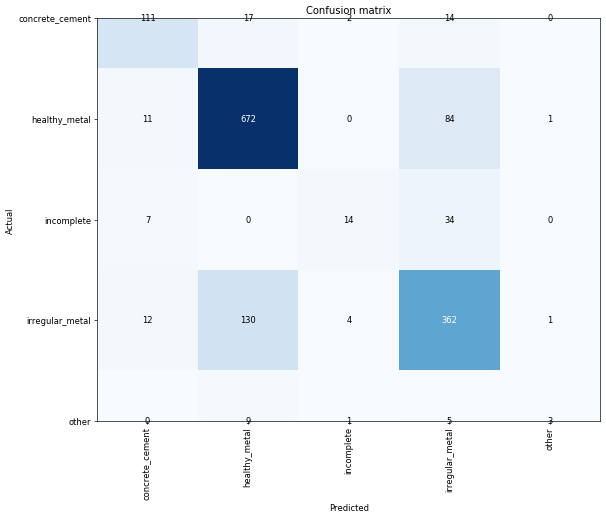

In [52]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [53]:
learn.unfreeze()

In [54]:
#learn.lr_find()
#learn.recorder.plot()

In [55]:

learn.fit_one_cycle(5, slice(1e-5, lr/5), callbacks=callbacks)

epoch,train_loss,valid_loss,error_rate,time
0,0.602786,0.554724,0.210843,02:54
1,0.576445,0.512044,0.202142,02:53
2,0.498762,0.518595,0.197456,02:53
3,0.452307,0.491563,0.187416,02:50
4,0.395815,0.490605,0.188755,02:52


Epoch 0 monitor valid_loss current: 0.5547242164611816 best: inf
Epoch 1 monitor valid_loss current: 0.512043833732605 best: 0.5547242164611816
Epoch 3 monitor valid_loss current: 0.49156326055526733 best: 0.512043833732605
Epoch 4 monitor valid_loss current: 0.4906047582626343 best: 0.49156326055526733


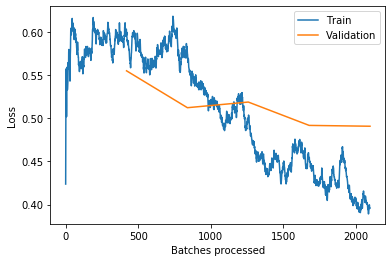

In [56]:
learn.recorder.plot_losses()

In [57]:
print(f'best-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

best-efficient_net_b4-06_16-efficientnet-20191128-3c19f55d


In [47]:
learn.load(f'best-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (13451 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/reflect/blk_cutoff_25/256;

Valid: LabelList (1494 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,healthy_metal,concrete_cement,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/reflect/blk_cutoff_25/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_02/train/rotated/clipped/reflect/blk_cutoff_25/256, model=Sequential(
  (0): Sequential(
    (0): EfficientNet(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
      )
      (_bn0)

In [48]:
learn = learn.to_fp32()

In [49]:
learn.export(f'best-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl')

### inference

In [96]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [97]:
len(test_dataset)

14650

In [98]:
learn = load_learner(path=train_images,file=f'best-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [99]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [100]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [101]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [102]:
len(learn.dl(DatasetType.Test))

229

In [103]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [104]:
labels = np.argmax(preds, 1)

In [105]:
len(preds)

14650

In [106]:
preds[0].tolist()

[0.016687048599123955,
 0.9684069156646729,
 0.0004706623440142721,
 0.010611006990075111,
 0.00382435810752213]

In [107]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [108]:
len(labels)

14650

In [109]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [110]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [111]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [112]:
test_predictions[0]

'healthy_metal'

In [113]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [114]:
 learn.data.test_ds.x.items

array([PosixPath('data_02/test/rotated/clipped/reflect/blk_cutoff_25/256/7a4d9168.tif'),
       PosixPath('data_02/test/rotated/clipped/reflect/blk_cutoff_25/256/7a4ae922.tif'),
       PosixPath('data_02/test/rotated/clipped/reflect/blk_cutoff_25/256/7a48ca98.tif'),
       PosixPath('data_02/test/rotated/clipped/reflect/blk_cutoff_25/256/7a4ba13c_rot90.tif'), ...,
       PosixPath('data_02/test/rotated/clipped/reflect/blk_cutoff_25/256/7a501f50.tif'),
       PosixPath('data_02/test/rotated/clipped/reflect/blk_cutoff_25/256/7a4cefa6_rot90.tif'),
       PosixPath('data_02/test/rotated/clipped/reflect/blk_cutoff_25/256/7a4ce7d6_rot90.tif'),
       PosixPath('data_02/test/rotated/clipped/reflect/blk_cutoff_25/256/7a4d27b4.tif')], dtype=object)

In [115]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [116]:
preds_list[0]

[0.016687048599123955,
 0.9684069156646729,
 0.0004706623440142721,
 0.010611006990075111,
 0.00382435810752213]

In [117]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [118]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [119]:
df.head()

,id,pred
0,7a4d9168,"[0.016687048599123955, 0.9684069156646729, 0.0..."
1,7a4ae922,"[0.019134357571601868, 0.8418117761611938, 0.0..."
2,7a48ca98,"[0.001425150316208601, 0.6632417440414429, 0.0..."
3,7a4ba13c_rot90,"[0.03029557876288891, 0.7675713896751404, 0.01..."
4,7a44e752_rot90,"[0.0002901539846789092, 0.02354489266872406, 0..."


In [120]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [121]:
pred_df.insert(loc=0, column='id', value=ids)

In [122]:
pred_df.columns = cols

In [123]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.016687,0.968407,0.000471,0.010611,0.003824
1,7a4ae922,0.019134,0.841812,0.057484,0.081530,0.000040
2,7a48ca98,0.001425,0.663242,0.000545,0.334423,0.000364
3,7a4ba13c_rot90,0.030296,0.767571,0.012438,0.186047,0.003648
4,7a44e752_rot90,0.000290,0.023545,0.009234,0.966854,0.000076


In [124]:
pred_ids=pred_df['id'].values.tolist()

In [125]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [126]:
df_baseline.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.093275,0.496369,0.044923,0.352455,0.012979
1,7a4bbbd6,0.093275,0.496369,0.044923,0.352455,0.012979
2,7a4ac744,0.093275,0.496369,0.044923,0.352455,0.012979
3,7a4881fa,0.093275,0.496369,0.044923,0.352455,0.012979
4,7a4aa4a8,0.093275,0.496369,0.044923,0.352455,0.012979


In [127]:
baseline_ids=df_baseline['id'].values.tolist()

In [128]:
baseline_ids

['7a4d630a',
 '7a4bbbd6',
 '7a4ac744',
 '7a4881fa',
 '7a4aa4a8',
 '7a514434',
 '7a485f72',
 '7a4b8d32',
 '7a47eb3c',
 '7a4be3ae',
 '7a46a330',
 '7a481620',
 '7a49c678',
 '7a4ea044',
 '7a47aa1e',
 '7a51aa1e',
 '7a498be0',
 '7a4a2848',
 '7a4c4cd6',
 '7a465038',
 '7a4e94aa',
 '7a49f62a',
 '7a45b6f0',
 '7a50bb90',
 '7a4d38e4',
 '7a48a3a6',
 '7a4ebe9e',
 '7a48352e',
 '7a4bfaec',
 '7a51e060',
 '7a4c0f5a',
 '7a4b9976',
 '7a4b27d4',
 '7a51c698',
 '7a474bb4',
 '7a480054',
 '7a4a4044',
 '7a4c35ca',
 '7a4d3fd8',
 '7a4c1a68',
 '7a4eb1c4',
 '7a4a51ce',
 '7a4a14fc',
 '7a5015d2',
 '7a4ba95c',
 '7a5101ae',
 '7a4d0a22',
 '7a5134ee',
 '7a4a85c2',
 '7a514b14',
 '7a4d0a90',
 '7a485fd6',
 '7a4f668c',
 '7a44e752',
 '7a5162d4',
 '7a465894',
 '7a4c9a10',
 '7a485810',
 '7a4a9788',
 '7a503198',
 '7a4e206a',
 '7a4c15ea',
 '7a4f8536',
 '7a513df4',
 '7a4d7624',
 '7a4c9e8e',
 '7a4b2554',
 '7a502b12',
 '7a4c32e6',
 '7a4a8a2c',
 '7a467b76',
 '7a51b554',
 '7a4622e8',
 '7a4a599e',
 '7a4d17c4',
 '7a4fb740',
 '7a4ceed4',

In [129]:
len(set(baseline_ids))

7325

In [130]:
len(set(pred_ids))

14650

In [131]:
pred_df = pred_df[~pred_df.id.str.contains('_')]

In [132]:
pred_ids=pred_df['id'].values.tolist()

In [133]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [134]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [135]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
0,7a4d9168,0.016687,0.968407,0.000471,0.010611,0.003824,7a4d9168
1,7a4ae922,0.019134,0.841812,0.057484,0.081530,0.000040,7a4ae922
2,7a48ca98,0.001425,0.663242,0.000545,0.334423,0.000364,7a48ca98
6,7a49c614,0.000048,0.964427,0.000104,0.035357,0.000065,7a49c614
7,7a4dd4f2,0.000124,0.941757,0.000668,0.054580,0.002871,7a4dd4f2


In [136]:
pred_df=pred_df.sort_values('id_cat')

In [137]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
1394,7a4d630a,0.000044,0.999116,0.000084,0.000755,0.000002,7a4d630a
1487,7a4bbbd6,0.000075,0.996378,0.000021,0.003410,0.000116,7a4bbbd6
3622,7a4ac744,0.006833,0.888611,0.004975,0.099541,0.000040,7a4ac744
6758,7a4881fa,0.000373,0.072658,0.037834,0.889108,0.000027,7a4881fa
259,7a4aa4a8,0.000717,0.823201,0.002014,0.173893,0.000175,7a4aa4a8


In [138]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [139]:
pred_df=pred_df.drop_duplicates(subset=['id'])

In [140]:
len(pred_df)

7325

In [141]:
len(df_test.id.values.tolist())

7594

In [142]:
a=df_test.id.values.tolist()
b=pred_df.id.values.tolist()
intersection = set(a) & set(b)
a_remainder = set(a) - set(b)
b_remainder = set(b) - set(a)

In [147]:
len(intersection)

0

In [145]:
len(a_remainder)

7594

In [146]:
len(b_remainder)

7325

In [94]:
## now just get the unverified preds
check_df = pred_df.loc[pred_df['id'].isin(df_test.id.values.tolist())]

In [95]:
pred_df.to_csv(data_dir/f'processing/best-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

In [154]:
print(f'processing/best-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

processing/best-efficient_net_b4-06_16-efficientnet-20191128-3c19f55d.csv


In [ ]:
### Submission 2: 0.4461
